## Load needed modules and define path to data

In [1]:
on_aws = False
import time # only needed to time differnet algorithms

In [2]:
#for editing wav files to text
from pydub import AudioSegment 
from pydub.playback import play
from pydub.utils import mediainfo

In [3]:
#for speech to text
import speech_recognition as sr

In [4]:
#for pyannote-audio's diarisation
import torch
from huggingface_hub import HfApi
available_pipelines = [p.modelId for p in HfApi().list_models(filter="pyannote-audio-pipeline")]
available_pipelines

['pyannote/speaker-diarization',
 'pyannote/overlapped-speech-detection',
 'pyannote/voice-activity-detection',
 'pyannote/speaker-segmentation']

In [5]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

In [6]:
# list files in tarxya bucket
if on_aws:
    !aws s3 ls voicetarxya/purchased/

In [7]:
# specify the audio file and the desired window
if on_aws:
    print("ON AWS!")
    !aws s3 cp s3://voicetarxya/purchased/in-443303309465-07449988008-20190624-110909-1561370949.138008.wav test_audio_from_s3.wav
    #!aws s3 cp s3://voicetarxya/purchased/q-801-1562945353.213997.wav test_audio_from_s3.wav
    !ls *wav
    base = "test_audio_from_s3" 
    audio = base + ".wav" 
    GLOBAL_START = 0. 
    GLOBAL_END = 60. 
if not on_aws:
    print("NOT ON AWS!")
    !ls *wav
    base = "audio" 
    audio = base + ".wav"
    GLOBAL_START = 0.
    GLOBAL_END = 632.

NOT ON AWS!
audio.wav  bin.wav  segmentino.wav  segment.wav


## use pydub to edit the audio file 

In [8]:
wav_file = AudioSegment.from_file(file = "audio.wav", format = "wav")
info = mediainfo("audio.wav")
ratio = float(len(wav_file))/float(info["duration_ts"])
sample_rate = wav_file.frame_rate*ratio
start_index = int(GLOBAL_START*sample_rate)
end_index = int(GLOBAL_END*sample_rate)

In [9]:
modified_wav_file = wav_file[start_index:end_index]
modified_wav_file.export(out_f = "segment.wav" , format = "wav")

<_io.BufferedRandom name='segment.wav'>

In [10]:
# Audio file
modified_wav_file

## Speech to text on specified time segment

In [11]:
r = sr.Recognizer()
audio_sr = sr.AudioFile("segment.wav")



In [12]:
start_time = time.time()
with audio_sr as source:
    audiodata = r.record(source)#, offset=GLOBAL_START, duration = GLOBAL_END-GLOBAL_START)
try:
    print(r.recognize_google(audiodata,language="en-GB"))
except Exception as e:
    print("Error : " + str(e))
end_time = time.time()
print("\nTime taken : ",end_time-start_time)

Error : 

Time taken :  14.072980880737305


# WARNING THE NEXT CELL IS SLOW TO RUN, DONT RUN UNLESS NEED!
## this performs the diarisation on the entire audio file, it takes a while to run

In [13]:
# diarization
start_time = time.time()
dia = pipeline("segment.wav")
end_time = time.time()
end_time = time.time()
print("\nTime taken : ",end_time-start_time)


Time taken :  401.27347922325134


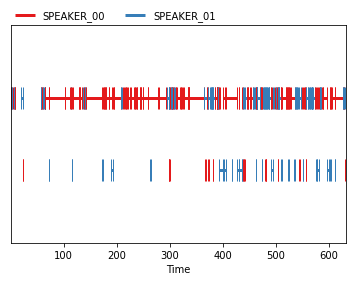

In [14]:
# plot whole dia
dia

In [15]:
# this can be used to crop the diarization if you dont do that before
# crop time interval and replot
#from pyannote.core import notebook, Segment
#notebook.crop = Segment(GLOBAL_START, GLOBAL_END)
#dia

## Print out resulting time buckets of diarisation within desired time section
## Visualise the output 

In [16]:
for turn, _, speaker in dia.itertracks(yield_label=True):
    if (True):#turn.start > GLOBAL_START and turn.start < GLOBAL_END):
        print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=0.5s stop=1.8s speaker_SPEAKER_00
start=2.6s stop=3.8s speaker_SPEAKER_01
start=4.5s stop=6.6s speaker_SPEAKER_00
start=7.1s stop=8.0s speaker_SPEAKER_01
start=8.5s stop=9.5s speaker_SPEAKER_00
start=20.8s stop=23.2s speaker_SPEAKER_01
start=22.8s stop=23.0s speaker_SPEAKER_00
start=57.1s stop=57.9s speaker_SPEAKER_00
start=58.5s stop=59.4s speaker_SPEAKER_01
start=59.7s stop=61.6s speaker_SPEAKER_00
start=62.3s stop=63.9s speaker_SPEAKER_01
start=64.3s stop=64.5s speaker_SPEAKER_01
start=64.5s stop=64.6s speaker_SPEAKER_00
start=64.6s stop=65.1s speaker_SPEAKER_01
start=65.5s stop=73.2s speaker_SPEAKER_00
start=72.1s stop=73.0s speaker_SPEAKER_01
start=73.5s stop=102.1s speaker_SPEAKER_00
start=102.5s stop=112.9s speaker_SPEAKER_00
start=113.6s stop=114.0s speaker_SPEAKER_01
start=114.4s stop=116.4s speaker_SPEAKER_00
start=116.2s stop=116.4s speaker_SPEAKER_01
start=117.5s stop=129.9s speaker_SPEAKER_00
start=130.1s stop=131.6s speaker_SPEAKER_00
start=131.9s stop=134.4s speake

## Speech recognition on the above diarisation time bins and output with labelled speakers

In [17]:
r = sr.Recognizer()
audio_sr = sr.AudioFile("segment.wav")
!ls *wav

audio.wav  bin.wav  segmentino.wav  segment.wav


In [18]:
for turn, _, speaker in dia.itertracks(yield_label=True):
    start_time = turn.start
    end_time = turn.end
    if (True):#turn.start > GLOBAL_START and turn.start < GLOBAL_END):
        with audio_sr as source:
            audiodata = r.record(source, offset=start_time-0.1, duration = end_time-start_time+0.1)
        try:
            words = r.recognize_google(audiodata,language="en-GB")
            print(f"*------------------------START---------t={turn.start:.1f}s--------*")
            print(f"{speaker} : {words}")
            print("")
            print(f"*-------------------------END----------t={turn.end:.1f}s--------*")
        except Exception as e:
            print(f"{speaker} : ???")
            print("")
        

*------------------------START---------t=0.5s--------*
SPEAKER_00 : good

*-------------------------END----------t=1.8s--------*
SPEAKER_01 : ???

*------------------------START---------t=4.5s--------*
SPEAKER_00 : I can see if it's available

*-------------------------END----------t=6.6s--------*
SPEAKER_01 : ???

SPEAKER_00 : ???

*------------------------START---------t=20.8s--------*
SPEAKER_01 : transfer you through search

*-------------------------END----------t=23.2s--------*
SPEAKER_00 : ???

SPEAKER_00 : ???

SPEAKER_01 : ???

*------------------------START---------t=59.7s--------*
SPEAKER_00 : not too bad not to

*-------------------------END----------t=61.6s--------*
*------------------------START---------t=62.3s--------*
SPEAKER_01 : alright

*-------------------------END----------t=63.9s--------*
SPEAKER_01 : ???

SPEAKER_00 : ???

SPEAKER_01 : ???

*------------------------START---------t=65.5s--------*
SPEAKER_00 : yeah it's been crazy at the centre to be honest with yo

*------------------------START---------t=326.3s--------*
SPEAKER_00 : we're most majority policies out there if it ever reached the point where your job is at risk

*-------------------------END----------t=333.9s--------*
SPEAKER_00 : ???

SPEAKER_00 : ???

*------------------------START---------t=337.1s--------*
SPEAKER_00 : if within the initial exclusion period you found out that your job as there was restructuring going on within your department and division ok then that would automatically invalidate the policy but with this policy as well as that if within the initial exclusion period you find out that there's restructuring it's absolutely fine as long as you haven't been made aware that your job is at risk so it's just that there's a little bit of a layer of security within the within the initial exclusion period

*-------------------------END----------t=364.1s--------*
*------------------------START---------t=364.6s--------*
SPEAKER_01 : so the chief operating officer here so y

*------------------------START---------t=525.6s--------*
SPEAKER_00 : oh no not trading

*-------------------------END----------t=527.8s--------*
*------------------------START---------t=528.8s--------*
SPEAKER_00 : the second one is cash in but it goes automatically so that's holiday lettings and it automatically just get those

*-------------------------END----------t=536.6s--------*
*------------------------START---------t=535.0s--------*
SPEAKER_01 : actually just get

*-------------------------END----------t=537.0s--------*
SPEAKER_01 : ???

SPEAKER_01 : ???

*------------------------START---------t=540.1s--------*
SPEAKER_01 : and that money sit in the business

*-------------------------END----------t=542.9s--------*
*------------------------START---------t=544.3s--------*
SPEAKER_01 : yeah take it drawings and take any dividends

*-------------------------END----------t=548.4s--------*
SPEAKER_00 : ???

*------------------------START---------t=549.3s--------*
SPEAKER_00 : ok

*

## My attempt at stitching audio pieces together

##### idea here is that sometimes continuous speach by one speaker is broken into multiple chunks here, one long chunk is better for speech to text

In [19]:
# list each bin output from diariazation, some adjacent bins have the same speaker

speech_fragments = []
for turn, track, speaker in dia.itertracks(yield_label=True):
    if (True):#turn.end > GLOBAL_START and turn.start < GLOBAL_END):
        speech_fragments += [[speaker,turn.start,turn.end,"new"]]
        print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")
#for i in range(len(speech_fragments)): print(speech_fragments[i])

start=0.5s stop=1.8s speaker_SPEAKER_00
start=2.6s stop=3.8s speaker_SPEAKER_01
start=4.5s stop=6.6s speaker_SPEAKER_00
start=7.1s stop=8.0s speaker_SPEAKER_01
start=8.5s stop=9.5s speaker_SPEAKER_00
start=20.8s stop=23.2s speaker_SPEAKER_01
start=22.8s stop=23.0s speaker_SPEAKER_00
start=57.1s stop=57.9s speaker_SPEAKER_00
start=58.5s stop=59.4s speaker_SPEAKER_01
start=59.7s stop=61.6s speaker_SPEAKER_00
start=62.3s stop=63.9s speaker_SPEAKER_01
start=64.3s stop=64.5s speaker_SPEAKER_01
start=64.5s stop=64.6s speaker_SPEAKER_00
start=64.6s stop=65.1s speaker_SPEAKER_01
start=65.5s stop=73.2s speaker_SPEAKER_00
start=72.1s stop=73.0s speaker_SPEAKER_01
start=73.5s stop=102.1s speaker_SPEAKER_00
start=102.5s stop=112.9s speaker_SPEAKER_00
start=113.6s stop=114.0s speaker_SPEAKER_01
start=114.4s stop=116.4s speaker_SPEAKER_00
start=116.2s stop=116.4s speaker_SPEAKER_01
start=117.5s stop=129.9s speaker_SPEAKER_00
start=130.1s stop=131.6s speaker_SPEAKER_00
start=131.9s stop=134.4s speake

In [20]:
# label if speaker is new or repeated and 
# make the "new" buckets have start and end times that absorb the later buckets with same speaker

# the reverse loop is important as we want to pull the latest finish time to the first start time

for i in reversed(range(len(speech_fragments)-1)): 
    frag = speech_fragments[i]
    nextfrag = speech_fragments[i+1]
    if frag[0]==nextfrag[0]:
        nextfrag[1] = frag[1]
        frag[2]=nextfrag[2]
        nextfrag[3] = "repeat"
    
for frag in speech_fragments: print(frag)
        


['SPEAKER_00', 0.4771875000000001, 1.8103125000000002, 'new']
['SPEAKER_01', 2.5865625000000003, 3.818437500000001, 'new']
['SPEAKER_00', 4.4765625, 6.602812500000001, 'new']
['SPEAKER_01', 7.1090625, 8.037187500000002, 'new']
['SPEAKER_00', 8.492812500000003, 9.454687500000002, 'new']
['SPEAKER_01', 20.8284375, 23.1740625, 'new']
['SPEAKER_00', 22.8196875, 57.869062500000005, 'new']
['SPEAKER_00', 22.8196875, 57.869062500000005, 'repeat']
['SPEAKER_01', 58.510312500000005, 59.354062500000005, 'new']
['SPEAKER_00', 59.7084375, 61.64906250000001, 'new']
['SPEAKER_01', 62.27343750000001, 64.5178125, 'new']
['SPEAKER_01', 62.27343750000001, 64.5178125, 'repeat']
['SPEAKER_00', 64.5178125, 64.6359375, 'new']
['SPEAKER_01', 64.6359375, 65.1253125, 'new']
['SPEAKER_00', 65.51343750000001, 73.1915625, 'new']
['SPEAKER_01', 72.1284375, 72.9721875, 'new']
['SPEAKER_00', 73.51218750000001, 112.89843750000001, 'new']
['SPEAKER_00', 73.51218750000001, 112.89843750000001, 'repeat']
['SPEAKER_01', 1

In [21]:
# output the modified/grrouped buckets so that there are no more neighbouting buckets with same speaker

fixed_speech = []      
for frag in speech_fragments:
    if (frag[3]=="new"):
        fixed_speech += [frag]
        
for frag in fixed_speech: print(f"start={frag[1]:.1f}s stop={frag[2]:.1f}s speaker_{frag[0]}")
        

start=0.5s stop=1.8s speaker_SPEAKER_00
start=2.6s stop=3.8s speaker_SPEAKER_01
start=4.5s stop=6.6s speaker_SPEAKER_00
start=7.1s stop=8.0s speaker_SPEAKER_01
start=8.5s stop=9.5s speaker_SPEAKER_00
start=20.8s stop=23.2s speaker_SPEAKER_01
start=22.8s stop=57.9s speaker_SPEAKER_00
start=58.5s stop=59.4s speaker_SPEAKER_01
start=59.7s stop=61.6s speaker_SPEAKER_00
start=62.3s stop=64.5s speaker_SPEAKER_01
start=64.5s stop=64.6s speaker_SPEAKER_00
start=64.6s stop=65.1s speaker_SPEAKER_01
start=65.5s stop=73.2s speaker_SPEAKER_00
start=72.1s stop=73.0s speaker_SPEAKER_01
start=73.5s stop=112.9s speaker_SPEAKER_00
start=113.6s stop=114.0s speaker_SPEAKER_01
start=114.4s stop=116.4s speaker_SPEAKER_00
start=116.2s stop=116.4s speaker_SPEAKER_01
start=117.5s stop=134.4s speaker_SPEAKER_00
start=136.2s stop=138.6s speaker_SPEAKER_01
start=139.2s stop=139.6s speaker_SPEAKER_00
start=140.5s stop=141.8s speaker_SPEAKER_01
start=142.1s stop=172.5s speaker_SPEAKER_00
start=171.7s stop=173.7s sp

## Here print the STT on the grouped speech buckets

In [22]:
start_time = time.time()
for frag in fixed_speech:
    with audio_sr as source:
            audiodata = r.record(source, offset=frag[1]-0.1, duration = frag[2]-frag[1]+0.1)
    try:
        words = r.recognize_google(audiodata,language="en-GB")
        #print(f"*------------------------START---------t={frag[1]:.1f}s--------*")
        print(f"{frag[0]} : {words}")
        print("")
        #print(f"*-------------------------END----------t={frag[2]:.1f}s--------*")
    except Exception as e:
        #print(f"*------------------------START---------t={frag[1]:.1f}s--------*")
        print(f"{frag[0]} : ??? ")
        print("")
        #print(f"*-------------------------END----------t={frag[2]:.1f}s--------*")
end_time = time.time()
print(f"Transcript time : {end_time-start_time}s")
    

SPEAKER_00 : good

SPEAKER_01 : ??? 

SPEAKER_00 : I can see if it's available

SPEAKER_01 : ??? 

SPEAKER_00 : ??? 

SPEAKER_01 : transfer you through search

SPEAKER_00 : moment thanks

SPEAKER_01 : ??? 

SPEAKER_00 : not too bad not to

SPEAKER_01 : alright busy one today

SPEAKER_00 : ??? 

SPEAKER_01 : ??? 

SPEAKER_00 : yeah it's been crazy at the centre to be honest with you but it does make the day go nice and quick that's one thing

SPEAKER_01 : ??? 

SPEAKER_00 : ok lovely so I had a chat to attract one of the directors and the policy that we can provide is with a company called April UK and I actually I actually rang them as well and spoke to them and and just double check that they be able to provide you with the cover and and they said it's fine if you've got doorman businesses that's not a problem basically it is lovely it doesn't pose an issue now wait for UK the maximum that they pay as a monthly benefit there is £1,500 ok now what will you what were you looking for

SP

SPEAKER_00 : ??? 

SPEAKER_01 : ??? 

SPEAKER_00 : no ok right ok let me give him a call I'm not sure if they're still open now let me quickly try if I do get to speak to him this evening I'll come straight back to you obviously right but if I can't speak to the this evening what I'll do is I'll I'll pop your text message and let you know and then I'll speak to you tomorrow

SPEAKER_01 : let me quickly try if I do get to speak to him this evening I'll come straight back to you obviously right but if I can't speak to the this evening what I'll do is I'll I'll pop your text message and let you know and then I'll speak to you tomorrow morning ok ok

SPEAKER_00 : no problem at all so

SPEAKER_01 : ??? 

SPEAKER_00 : ??? 

Transcript time : 111.98446083068848s


## hand transcribed

SPEAKER_00 : yeah 

SPEAKER_01 : but none of it comes back out to me it's a limited company and it just says there the third one is umm there are four four of us it's a mental health trust 

SPEAKER_00 : yeah 

SPEAKER_01 : and the money just goes in to pay the employees salary I don't take anything from it 

SPEAKER_00 : errrr

SPEAKER_01 : and nor could I 

SPEAKER_00 : no no sure erm ok 

SPEAKER_01 : it's that I don't want to take it and then gum(?) someone goes ah well that wasn't our

SPEAKER_00 : no 

??? 

SPEAKER_00 : no no no what I'm going to do is I'll based on what you said is i'm going to ring up april(?) UK and clarify that with them cos I think it's important to so

SPEAKER_01 : yea

SPEAKER_00 : first one is it's open but there's nothing going in and 

SPEAKER_01 : or out it's not trading 

SPEAKER_00 : or out not trading ok the second one is cash in but it goes automatically so that's holiday lettings and it automatically just 

SPEAKER_01 : well yea it sits in the business it sits in the business it's a limited company

# To do

#### -> try ignoring bins of too small width or merge them with bigger bins
#### -> try messing with yield_label=True in the dia.intertracks
#### -> look into the _ argument too?
#### -> try extending bins to regions of no speech, maybe improves accuracy?
#### -> identify customer vs seller from use of works like I and me vs we or you? other indicators
#### -> write a wrappper function around the deepspeech as its a bit cumbersome.
#### -> maybe think about binning start and end buckets if they are too small, or finding the start/finish of buckets of they are slightly outside the diarization - might need to diarize t_0<->t_1 and t_0-delta <-> t_1+delta

## wordcounting

In [30]:
from collections import defaultdict
import re

start_time = time.time()
customer_counts = defaultdict(int)
seller_counts = defaultdict(int)
diff_counts = defaultdict(int)

for frag in fixed_speech:
    with audio_sr as source:
        audiodata = r.record(source, offset=frag[1]-0.1, duration = frag[2]-frag[1]+0.1)
    try:
        words = r.recognize_google(audiodata,language="en-GB")
        if frag[0] == 'SPEAKER_00':
            for word in re.findall('\w+', words.replace("'"," ")):
                diff_counts[word] -= 1
                customer_counts[word] += 1
        elif frag[0] == 'SPEAKER_01':
            for word in re.findall('\w+', words.replace("'"," ")):
                diff_counts[word] += 1
                seller_counts[word] += 1
    except Exception as e:
        pass

end_time = time.time()
print(f"Wordcount time : {end_time-start_time}s")



Wordcount time : 113.72303128242493s


In [31]:
marked_list = sorted(diff_counts.items(), key=lambda x:x[1])
sorted_diff_counts = dict(marked_list)
sorted_diff_counts

{'you': -37,
 'that': -19,
 'as': -19,
 'the': -18,
 'a': -16,
 'and': -13,
 'they': -13,
 's': -12,
 'yeah': -11,
 're': -11,
 'it': -10,
 'if': -9,
 'with': -9,
 'ok': -9,
 'of': -9,
 'is': -9,
 'UK': -9,
 'not': -8,
 'but': -8,
 'so': -8,
 'I': -7,
 'to': -7,
 'for': -7,
 'your': -7,
 'no': -7,
 'provide': -6,
 'just': -6,
 'got': -6,
 'will': -6,
 '1500': -6,
 'now': -5,
 'what': -5,
 'are': -5,
 'option': -5,
 'going': -5,
 'within': -5,
 'good': -4,
 'can': -4,
 'at': -4,
 'be': -4,
 'policy': -4,
 'actually': -4,
 'well': -4,
 'fine': -4,
 've': -4,
 'problem': -4,
 'basically': -4,
 'there': -4,
 'where': -4,
 'mean': -4,
 'then': -4,
 'have': -4,
 'out': -4,
 'long': -4,
 'lovely': -3,
 'we': -3,
 'them': -3,
 'said': -3,
 'businesses': -3,
 'were': -3,
 'looking': -3,
 'unfortunately': -3,
 'which': -3,
 'those': -3,
 'policies': -3,
 'risk': -3,
 'get': -3,
 'll': -3,
 'sickness': -3,
 'premium': -3,
 'course': -3,
 'initial': -3,
 'exclusion': -3,
 'job': -3,
 'automaticall

In [32]:
marked_list = sorted(customer_counts.items(), key=lambda x:x[1])
customer_counts = dict(marked_list)
customer_counts

{'available': 1,
 'thanks': 1,
 'bad': 1,
 'crazy': 1,
 'centre': 1,
 'honest': 1,
 'nice': 1,
 'quick': 1,
 'chat': 1,
 'attract': 1,
 'directors': 1,
 'company': 1,
 'called': 1,
 'April': 1,
 'rang': 1,
 'double': 1,
 'check': 1,
 'able': 1,
 'doorman': 1,
 'doesn': 1,
 'pose': 1,
 'issue': 1,
 'maximum': 1,
 'pay': 1,
 'monthly': 1,
 '1': 1,
 '500': 1,
 'facilitate': 1,
 'fact': 1,
 'say': 1,
 'terms': 1,
 'would': 1,
 'previous': 1,
 'mind': 1,
 'separate': 1,
 'ins': 1,
 'colleague': 1,
 'jacket': 1,
 'put': 1,
 'couple': 1,
 'through': 1,
 'similar': 1,
 'since': 1,
 'decision': 1,
 'd': 1,
 'rather': 1,
 'accepting': 1,
 'applications': 1,
 'people': 1,
 'who': 1,
 'Norman': 1,
 'director': 1,
 'Howard': 1,
 'over': 1,
 'however': 1,
 'he': 1,
 'look': 1,
 'details': 1,
 'idea': 1,
 'april': 1,
 'uk': 1,
 'wanted': 1,
 'tax': 1,
 'package': 1,
 'split': 1,
 'two': 1,
 'date': 1,
 'birth': 1,
 '01967': 1,
 'DE1': 1,
 '30': 1,
 'access': 1,
 'pays': 1,
 'A31': 1,
 '90': 1,
 '75':

In [33]:
marked_list = sorted(seller_counts.items(), key=lambda x:x[1])
seller_counts = dict(marked_list)
seller_counts

{'transfer': 1,
 'through': 1,
 'search': 1,
 'busy': 1,
 'today': 1,
 'won': 1,
 'with': 1,
 'Premium': 1,
 'protection': 1,
 '1309': 1,
 'well': 1,
 'bit': 1,
 'sore': 1,
 'corner': 1,
 'garage': 1,
 'annually': 1,
 'god': 1,
 'chief': 1,
 'operating': 1,
 'officer': 1,
 'here': 1,
 'make': 1,
 'myself': 1,
 'please': 1,
 'cos': 1,
 'marketing': 1,
 'agency': 1,
 'only': 1,
 '34': 1,
 'big': 1,
 'clients': 1,
 'move': 1,
 'look': 1,
 'dormant': 1,
 'qualify': 1,
 'doorman': 1,
 'those': 1,
 'an': 1,
 'Dawn': 1,
 'up': 1,
 'companies': 1,
 'House': 1,
 'absolutely': 1,
 'fine': 1,
 'put': 1,
 'savings': 1,
 'fund': 1,
 'children': 1,
 'trading': 1,
 'guess': 1,
 'my': 1,
 'p': 1,
 'whatever': 1,
 '45': 1,
 '60': 1,
 'all': 1,
 'businesses': 1,
 'alive': 1,
 'was': 1,
 'running': 1,
 'training': 1,
 'consultancy': 1,
 'happening': 1,
 'anymore': 1,
 'more': 1,
 'second': 1,
 'cash': 1,
 'people': 1,
 'lodges': 1,
 'none': 1,
 'comes': 1,
 'out': 1,
 'says': 1,
 'third': 1,
 'four': 1,


In [34]:
string_thing = "hello hello here is a listy poo of words yes yes hello"
splitted = string_thing.split()
print(string_thing)
splitted

hello hello here is a listy poo of words yes yes hello


['hello',
 'hello',
 'here',
 'is',
 'a',
 'listy',
 'poo',
 'of',
 'words',
 'yes',
 'yes',
 'hello']